# Desafio - Banco Bradesco
Rafael Eiki Teruya

## Carregando as bibliotecas

In [814]:
import yfinance as yf
from bcb import sgs
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform
from sklearn.covariance import LedoitWolf
from sklearn.utils import resample
import matplotlib.pyplot as plt

## Carregando os dados

In [876]:
# Carregando os tickers pelo yfinance
tickers = ['^BVSP', '^GSPC', '^VIX', 'USDBRL=X']
dados = yf.download(tickers,start='2010-01-01', end='2025-01-01', auto_adjust=True).Close
dados

[*********************100%***********************]  4 of 4 completed


Ticker,USDBRL=X,^BVSP,^GSPC,^VIX
Date,,,,
2010-01-04,1.7190,70045.0,1132.989990,20.040001
2010-01-05,1.7370,70240.0,1136.520020,19.350000
2010-01-06,1.7315,70729.0,1137.140015,19.160000
2010-01-07,1.7389,70451.0,1141.689941,19.059999
2010-01-08,1.7320,70263.0,1144.979980,18.129999
...,...,...,...,...
2024-12-25,6.1756,NaN,NaN,NaN
2024-12-26,6.1828,121078.0,6037.589844,14.730000
2024-12-27,6.1485,120269.0,5970.839844,15.950000


In [877]:
# Carregando o IPCA pelo SGS do BCB
ipca = sgs.get(433, start='2010-01-01', end='2025-01-01')

# Converter para decimal
ipca = ipca/100

variacao_ipca = ipca

vol_mensal_ipca = []
for i in range(1, len(ipca)):
    vol_mensal_ipca.append(np.std(ipca[i-1:i+11].values)*np.sqrt(12))
vol_mensal_ipca = np.array(vol_mensal_ipca)

variacao_ipca = np.array(variacao_ipca)
variacao_ipca[np.isinf(variacao_ipca)] = np.nan
variacao_ipca = pd.DataFrame(variacao_ipca).dropna()

# Convertendo para frequência diária
ipca_diario = ipca.asfreq('D').ffill().iloc[:-1]

# Convertendo o IPCA mensal para diário
n_dias_mes = ipca_diario.index.days_in_month
for i in range(len(n_dias_mes)):
    ipca_diario.iloc[i] = (1 + ipca_diario.iloc[i])**(1/n_dias_mes[i]) - 1
ipca_diario


,433
Date,
2010-01-01,0.000241
2010-01-02,0.000241
2010-01-03,0.000241
2010-01-04,0.000241
2010-01-05,0.000241
...,...
2024-12-27,0.000167
2024-12-28,0.000167
2024-12-29,0.000167


In [879]:
# Carregando os dados do ouro baixados no Kaggle
ouro = pd.read_csv('Downloads/XAU_1d_data.csv', sep=';', index_col=0).Close

# Filtrando a série e formatando o índice
ouro = ouro.loc['2010.01.02':'2025.01.01']
ouro.index = pd.to_datetime(ouro.index, format='mixed')
ouro

Date
2010-01-04    1121.05
2010-01-05    1117.65
2010-01-06    1137.15
2010-01-07    1131.45
2010-01-08    1138.25
               ...   
2024-12-24    2616.59
2024-12-26    2633.53
2024-12-27    2621.54
2024-12-30    2605.96
2024-12-31    2624.61
Name: Close, Length: 3865, dtype: float64

In [880]:
# Juntando as séries em um DataFrame
cotacoes = pd.concat([dados, ipca_diario, ouro], axis=1)
cotacoes

,USDBRL=X,^BVSP,^GSPC,^VIX,433,Close
Date,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,0.000241,NaN
2010-01-02,NaN,NaN,NaN,NaN,0.000241,NaN
2010-01-03,NaN,NaN,NaN,NaN,0.000241,NaN
2010-01-04,1.7190,70045.0,1132.989990,20.040001,0.000241,1121.05
2010-01-05,1.7370,70240.0,1136.520020,19.350000,0.000241,1117.65
...,...,...,...,...,...,...
2024-12-27,6.1485,120269.0,5970.839844,15.950000,0.000167,2621.54
2024-12-28,NaN,NaN,NaN,NaN,0.000167,NaN
2024-12-29,NaN,NaN,NaN,NaN,0.000167,NaN


In [881]:
# Tratando os dados faltantes
cotacoes = cotacoes.ffill()
cotacoes = cotacoes.dropna()
cotacoes = cotacoes.reset_index()
cotacoes = cotacoes.set_index('Date')

In [882]:
# Renomeando as colunas para o artigo
cotacoes.rename(columns={'USDBRL=X':'Dollar', '^BVSP':'IBOVESPA', '^GSPC':'S&P500', '^VIX':'VIX'
                         , '433':'IPCA', 'Close':'Gold Spot'}, inplace=True)
cotacoes

,Dollar,IBOVESPA,S&P500,VIX,IPCA,Gold Spot
Date,,,,,,
2010-01-04,1.7190,70045.0,1132.989990,20.040001,0.000241,1121.05
2010-01-05,1.7370,70240.0,1136.520020,19.350000,0.000241,1117.65
2010-01-06,1.7315,70729.0,1137.140015,19.160000,0.000241,1137.15
2010-01-07,1.7389,70451.0,1141.689941,19.059999,0.000241,1131.45
2010-01-08,1.7320,70263.0,1144.979980,18.129999,0.000241,1138.25
...,...,...,...,...,...,...
2024-12-27,6.1485,120269.0,5970.839844,15.950000,0.000167,2621.54
2024-12-28,6.1485,120269.0,5970.839844,15.950000,0.000167,2621.54
2024-12-29,6.1485,120269.0,5970.839844,15.950000,0.000167,2621.54


## Calculando retornos, volatilidade e correlação dos ativos

In [883]:
# Calculando retornos, volatilidade e correlação diária
ret_diario = cotacoes.pct_change()
ret_diario['IPCA'] = ipca_diario
vol_diario = ret_diario.std()
corr_diaria = ret_diario.corr()

# Mensal
ret_mensal = cotacoes.resample('ME').last().pct_change().dropna()
ret_mensal['IPCA'] = np.array(ipca)[:-2]
vol_mensal = ret_diario.groupby(ret_diario.index.to_period('M')).std()*np.sqrt(21)
vol_mensal = vol_mensal
vol_mensal['IPCA'] = vol_mensal_ipca
corr_mensal = ret_diario.groupby(ret_diario.index.to_period('M')).apply(lambda x: x.corr())

# Anual
ret_anual = cotacoes.resample('YE').last().pct_change().dropna()
ret_anual['IPCA'] = ipca.resample('YE').apply(lambda x: ((1 + x).prod() - 1))
vol_anual = ret_diario.groupby(ret_diario.index.to_period('Y')).std()*np.sqrt(252)
vol_anual['IPCA'] = pd.DataFrame(vol_mensal['IPCA']).resample('Y').mean()*np.sqrt(12)
corr_anual = ret_diario.groupby(ret_diario.index.to_period('Y')).apply(lambda x: x.corr())

C:\Users\Rafael\AppData\Local\Temp\ipykernel_20424\4171757404.py:19: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  vol_anual['IPCA'] = pd.DataFrame(vol_mensal['IPCA']).resample('Y').mean()*np.sqrt(12)


In [884]:
# Criando tabelas resumo

# Retornos 2024
retornos_ultimo = pd.DataFrame({
    'Daily': ret_diario.iloc[-1,:],
    'Monthly': ret_mensal.iloc[-1,:],
    'Annual': ret_anual.iloc[-1,:]
})

# Volatilidades 2024
volatilidades_ultimo = pd.DataFrame({
    'Daily': vol_diario,
    'Monthly': vol_mensal.iloc[-1,:],
    'Annual': vol_anual.iloc[-1,:]
})

# Correlação 2024
correlacao_ultimo = corr_anual.loc['2024']


In [885]:
# Tabela de correlacao
tabela_correlacao = correlacao_ultimo*100
tabela_correlacao = tabela_correlacao.style.format("{:.2f}%")
tabela_correlacao

,Dollar,IBOVESPA,S&P500,VIX,IPCA,Gold Spot
Dollar,100.00%,-1.28%,-2.58%,-3.31%,-0.13%,5.13%
IBOVESPA,-1.28%,100.00%,26.12%,-30.26%,-6.81%,26.09%
S&P500,-2.58%,26.12%,100.00%,-76.69%,0.18%,23.76%
VIX,-3.31%,-30.26%,-76.69%,100.00%,0.26%,-20.11%
IPCA,-0.13%,-6.81%,0.18%,0.26%,100.00%,-3.61%
Gold Spot,5.13%,26.09%,23.76%,-20.11%,-3.61%,100.00%


In [886]:
# Tabela de retornos
retornos_ultimo = retornos_ultimo*100
retornos_ultimo = retornos_ultimo.style.format("{:.3f}%")
retornos_ultimo

,Daily,Monthly,Annual
Dollar,-0.255%,2.727%,27.374%
IBOVESPA,0.000%,-4.285%,-10.360%
S&P500,-0.428%,-2.499%,23.309%
VIX,-0.287%,28.423%,39.357%
IPCA,0.017%,0.390%,4.831%
Gold Spot,0.716%,-0.970%,27.243%


In [887]:
# Tabela de volatilidades
volatilidades_ultimo = volatilidades_ultimo*100
volatilidades_ultimo = volatilidades_ultimo.style.format("{:.2f}%")
volatilidades_ultimo

,Daily,Monthly,Annual
Dollar,0.91%,4.66%,10.65%
IBOVESPA,1.22%,4.56%,10.65%
S&P500,0.90%,3.37%,10.51%
VIX,6.86%,69.36%,124.30%
IPCA,0.01%,0.62%,2.15%
Gold Spot,0.80%,3.34%,12.62%


In [826]:
# Função para calcular o CVaR histórico
def cvar_historico(returns, alpha=0.05):
    returns = returns.dropna()
    var = np.percentile(returns, 100 * alpha)
    cvar = returns[returns <= var].mean()
    return cvar

# Construindo um DataFrame com os CVaRs
cvar_list = []
for column in ret_diario.columns:
    cvar_list.append({'Asset': column, 'CVaR_5%': cvar_historico(ret_diario[column].dropna(), alpha=0.05)})
cvar_df = pd.DataFrame(cvar_list)
cvar_df = cvar_df.sort_values(by="CVaR_5%", ascending=True)
cvar_df.style.format({"CVaR_5%": "{:.2%}"})


,Asset,CVaR_5%
3,VIX,-12.52%
1,IBOVESPA,-2.89%
2,S&P500,-2.29%
0,Dollar,-2.15%
5,Gold Spot,-2.00%
4,IPCA,-0.01%


## Otimização do Portfólio por HRP

In [827]:
# Retornos para o período de treino para otimização de portfólio (até 2019-12-31) com o intuito de evitar lookahead bias
retornos_treino = ret_diario[['Dollar', 'IBOVESPA', 'S&P500', 'Gold Spot']].loc[:'2019-12-31']
retornos_treino = retornos_treino.dropna()
retornos_treino

,Dollar,IBOVESPA,S&P500,Gold Spot
Date,,,,
2010-01-05,0.010471,0.002784,0.003116,-0.003033
2010-01-06,-0.003166,0.006962,0.000546,0.017447
2010-01-07,0.004274,-0.003930,0.004001,-0.005013
2010-01-08,-0.003968,-0.002669,0.002882,0.006010
2010-01-09,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-12-27,-0.006931,-0.005708,0.000034,-0.000271
2019-12-28,0.000000,0.000000,0.000000,0.000000
2019-12-29,0.000000,0.000000,0.000000,0.000000


In [828]:
# Função para converter correlação em distância
def correlacao_distancia(corr):
    return np.sqrt((1 - corr) / 2)

# Função para calcular a matriz de covariância robusta usando Ledoit-Wolf
def cov_robusta(retornos):
    X = retornos.dropna(axis=0, how='any')
    lw = LedoitWolf().fit(X)
    return pd.DataFrame(lw.covariance_, index=X.columns, columns=X.columns)

# Função para converter matriz de covariância em matriz de correlação
def cov_correlacao(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1] = -1
    corr[corr > 1] = 1
    return pd.DataFrame(corr, index=cov.index, columns=cov.columns)

# Função para ordenar os ativos de forma hierárquica
def quasi_diag(matriz_linkage, labels):
    ordem = leaves_list(matriz_linkage)
    return labels[ordem]

# Função para calcular a variância de um cluster de variáveis
def var_cluster(cov, items):
    sub_cov = cov.loc[items, items].values
    ivp = 1. / np.diag(sub_cov)
    ivp /= ivp.sum()
    var = ivp @ sub_cov @ ivp
    return float(var)

# Função para calcular os pesos com bisecção recursiva
def bissecção_recursiva(cov, items_ordenados):

    # iniciando os pesos
    pesos = pd.Series(1, index=items_ordenados)
    clusters = [list(items_ordenados)]

    # calculando a variância de cada cluster
    while clusters:
        cluster = clusters.pop(0)
        if len(cluster) == 1:
            continue
        split = len(cluster) // 2
        esquerda = cluster[:split]
        direita = cluster[split:]
        var_esquerda = var_cluster(cov, esquerda)
        var_direita = var_cluster(cov, direita)

        # alocando os pesos
        alpha = 1 - var_esquerda / (var_esquerda + var_direita)
        pesos[esquerda] = pesos[esquerda].astype(float) * alpha
        pesos[direita] = pesos[direita].astype(float) * (1 - alpha)
        if len(esquerda) > 1:
            clusters.append(esquerda)
        if len(direita) > 1:
            clusters.append(direita)
    return pesos/pesos.sum()

# Função principal para HRP
def otimizacao_hrp(retornos):
    labels = retornos.columns.to_numpy()
    
    cov = cov_robusta(retornos)
    corr = cov_correlacao(cov)

    dist = correlacao_distancia(corr)
    dist_condensada = squareform(dist.values, checks=False)

    Z = linkage(dist_condensada, method='single')

    ordered = quasi_diag(Z, labels)

    pesos = bissecção_recursiva(cov, ordered)

    return pesos

In [829]:
# Calculando os pesos usando HRP
ret_diario = ret_diario.dropna()
pesos = otimizacao_hrp(retornos_treino)
pesos

C:\Users\Rafael\AppData\Local\Temp\ipykernel_20424\1144429861.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.62579546 0.62579546]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pesos[esquerda] = pesos[esquerda].astype(float) * alpha


Dollar       0.270712
Gold Spot    0.355083
IBOVESPA     0.116359
S&P500       0.257845
dtype: float64

## Métricas do Portfólio

In [830]:
# Calculando o retorno do portfólio
portfolio_ret = ret_diario[['Dollar', 'IBOVESPA', 'S&P500', 'Gold Spot']].loc['2020-01-02':'2024-12-30'] @ pesos

# Cálculo do retorno acumulado do portfólio
portfolio_cum = (1 + portfolio_ret).cumprod() - 1

portfolio_cum

Date
2020-01-02    0.006686
2020-01-03    0.009781
2020-01-04    0.009781
2020-01-05    0.009781
2020-01-06    0.015435
                ...   
2024-12-26    0.710617
2024-12-27    0.699076
2024-12-28    0.699076
2024-12-29    0.699076
2024-12-30    0.699076
Length: 1825, dtype: float64

In [831]:
# Construindo um DataFrame com os retornos anuais dos ativos
ativo_ret_anual = pd.DataFrame({
    'Dollar': ret_diario['Dollar'].loc['2020-01-01':'2024-12-30'].resample('YE').apply(lambda x: (1 + x).prod() - 1),
    'IBOVESPA': ret_diario['IBOVESPA'].loc['2020-01-01':'2024-12-30'].resample('YE').apply(lambda x: (1 + x).prod() - 1),
    'S&P500': ret_diario['S&P500'].loc['2020-01-01':'2024-12-30'].resample('YE').apply(lambda x: (1 + x).prod() - 1),
    'Gold Spot': ret_diario['Gold Spot'].loc['2020-01-01':'2024-12-30'].resample('YE').apply(lambda x: (1 + x).prod() - 1)
})
ativo_ret_anual

,Dollar,IBOVESPA,S&P500,Gold Spot
Date,,,,
2020-12-31,0.292633,0.028819,0.162589,0.245301
2021-12-31,0.073083,-0.121402,0.268927,-0.034583
2022-12-31,-0.051273,0.049694,-0.194428,-0.002051
2023-12-31,-0.082201,0.219520,0.242305,0.130726
2024-12-31,0.267680,-0.103708,0.251793,0.270945


In [832]:
# Volatilidade da estratégia, por ano (2020-2024)
retornos_por_ano = portfolio_ret.loc['2020-01-01':'2024-12-30'].groupby(portfolio_ret.index.year)
vol_por_ano_diaria = retornos_por_ano.std()
vol_por_ano_anual = vol_por_ano_diaria*(252**0.5)
vol_por_ano_anual*100

Date
2020    13.967136
2021     7.540219
2022     9.236254
2023     6.035096
2024     6.969002
dtype: float64

In [833]:
# Criando um DataFrame com os retornos anuais dos ativos e da estratégia, volatilidade anual da estratégia e média anual do VIX e inflação anual
ativo_ret_anual['Média Anual VIX'] = dados['^VIX'].loc['2020-01-01':'2024-12-30'].resample('YE').mean()
ativo_ret_anual['Annual Inflation'] = ipca_diario.loc['2020-01-01':'2024-12-30'].resample('YE').apply(lambda x: 100*((1 + x).prod() - 1))
ativo_ret_anual['Strategy Returns'] = portfolio_ret.loc['2020-01-01':'2024-12-30'].resample('YE').apply(lambda x: (1 + x).prod() - 1)
ativo_ret_anual['Strategy Volatility'] = portfolio_ret.loc['2020-01-01':'2024-12-30'].resample('YE').std()*(np.sqrt(252))
ativo_ret_anual[['Dollar', 'IBOVESPA', 'S&P500', 'Gold Spot', 'Strategy Returns', 'Strategy Volatility']] = ativo_ret_anual[['Dollar', 'IBOVESPA', 'S&P500', 'Gold Spot', 'Strategy Returns', 'Strategy Volatility']].apply(lambda x: x*100)
ativo_ret_anual.index = ativo_ret_anual.index.strftime('%Y')
ativo_ret_anual['Portfolio Weight (HRP)'] = np.append(pesos*100, np.nan)
ativo_ret_anual.map(lambda x: f"{x:.2f}%")

,Dollar,IBOVESPA,S&P500,Gold Spot,Média Anual VIX,Annual Inflation,Strategy Returns,Strategy Volatility,Portfolio Weight (HRP)
Date,,,,,,,,,
2020,29.26%,2.88%,16.26%,24.53%,29.25%,4.52%,24.09%,13.97%,27.07%
2021,7.31%,-12.14%,26.89%,-3.46%,19.66%,10.06%,6.26%,7.54%,35.51%
2022,-5.13%,4.97%,-19.44%,-0.21%,25.62%,5.78%,-5.13%,9.24%,11.64%
2023,-8.22%,21.95%,24.23%,13.07%,16.87%,4.62%,11.17%,6.04%,25.78%
2024,26.77%,-10.37%,25.18%,27.09%,15.59%,4.81%,22.18%,6.97%,nan%


In [834]:
# Calculando a volatilidade anual dos ativos
vol_anual = ret_diario[['Dollar', 'IBOVESPA', 'S&P500', 'Gold Spot']].loc['2020-01-01':'2024-12-30'].resample('YE').std()*100*np.sqrt(252)
vol_anual.index = vol_anual.index.strftime('%Y')
vol_anual.T.style.format("{:.2f}%")

Date,2020,2021,2022,2023,2024
Dollar,18.74%,14.04%,15.23%,10.19%,10.64%
IBOVESPA,36.75%,17.20%,17.45%,14.25%,10.66%
S&P500,28.62%,10.90%,20.04%,10.85%,10.47%
Gold Spot,15.90%,11.29%,12.47%,11.06%,12.61%


## Visualizações gráficas

### Gráfico do retorno por ativo e ano

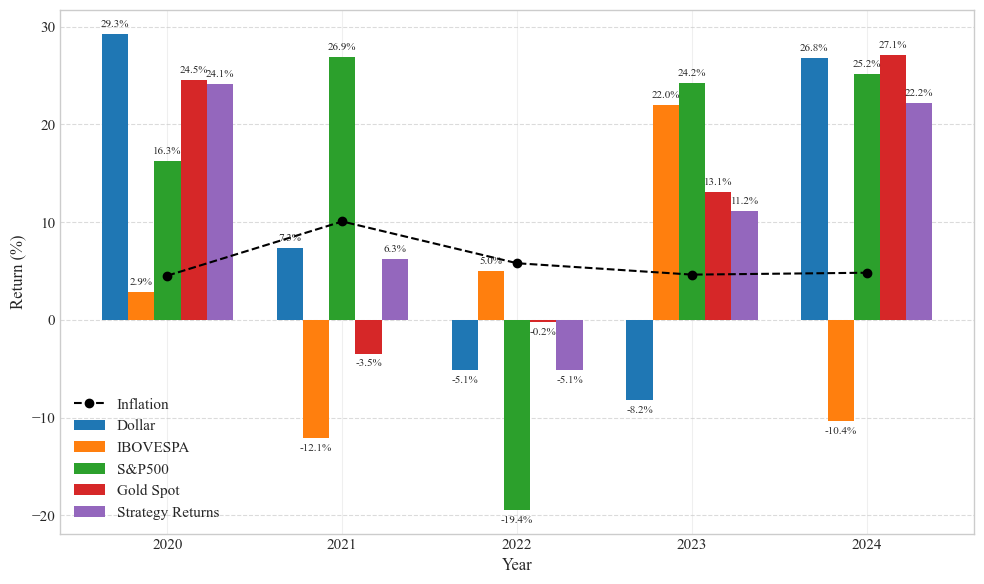

In [835]:
plt.style.use("seaborn-v0_8-whitegrid")

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.tab10.colors)


plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.figsize': (10,6),
    'axes.grid': True,
    'grid.alpha': 0.3
})


# Configurações do grafico
x = np.arange(len(ativo_ret_anual.index))  
width = 0.15  

# Criando a figura e os axes
fig, ax = plt.subplots(figsize=(10,6))


# Barras para cada ativo e a estratégia

ax.bar(x - 2*width, ativo_ret_anual["Dollar"], width, label="Dollar")
ax.bar(x - width, ativo_ret_anual["IBOVESPA"], width, label="IBOVESPA")
ax.bar(x, ativo_ret_anual["S&P500"], width, label="S&P500")
ax.bar(x + width, ativo_ret_anual["Gold Spot"], width, label="Gold Spot")
ax.bar(x + 2*width, ativo_ret_anual["Strategy Returns"], width, label="Strategy Returns")

for i, col in enumerate(["Dollar", "IBOVESPA", "S&P500", "Gold Spot", "Strategy Returns"]):
    positions = x + (i-2)*width
    for xi, y in zip(positions, ativo_ret_anual[col]):
        if y >= 0:
            ax.text(xi, y + 0.5, f"{y:.1f}%", ha='center', va='bottom', fontsize=8, rotation=0)
        else:
            ax.text(xi, y - 0.5, f"{y:.1f}%", ha='center', va='top', fontsize=8, rotation=0)


# Linha pontilhada da inflação
ax.plot(x, ativo_ret_anual["Annual Inflation"], color="black", marker="o", linestyle="--", label="Inflation")


ax.set_xlabel("Year")
ax.set_ylabel("Return (%)")
ax.set_xticks(x)
ax.set_xticklabels(['2020', '2021', '2022', '2023', '2024'])
ax.legend(loc='lower left')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Gráfico da volatilidade por ano e ativo

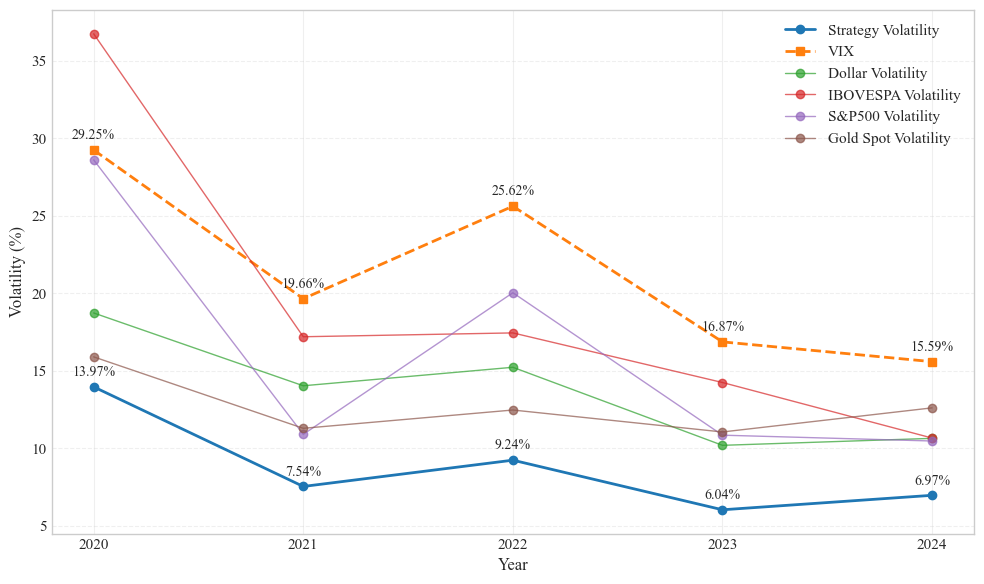

In [836]:
x = np.arange(len(ativo_ret_anual))

fig, ax = plt.subplots(figsize=(10,6))

# Linha da estratégia
ax.plot(x, ativo_ret_anual["Strategy Volatility"], marker="o", linestyle="-", label="Strategy Volatility", linewidth=2)

# Linha do VIX
ax.plot(x, ativo_ret_anual["Média Anual VIX"], marker="s", linestyle="--", label="VIX", linewidth=2)

# Linhas dos ativos
ax.plot(x, vol_anual["Dollar"], marker="o", linestyle="-", label="Dollar Volatility", linewidth=1, alpha=0.7)
ax.plot(x, vol_anual["IBOVESPA"], marker="o", linestyle="-", label="IBOVESPA Volatility", linewidth=1, alpha=0.7)
ax.plot(x, vol_anual["S&P500"], marker="o", linestyle="-", label="S&P500 Volatility", linewidth=1, alpha=0.7)
ax.plot(x, vol_anual["Gold Spot"], marker="o", linestyle="-", label="Gold Spot Volatility", linewidth=1, alpha=0.7)

# Adicionar valores acima dos pontos
for xi, y in zip(x, ativo_ret_anual["Strategy Volatility"]):
    ax.text(xi, y + .5, f"{y:.2f}%", ha='center', va='bottom', fontsize=10)
for xi, y in zip(x, ativo_ret_anual["Média Anual VIX"]):
    ax.text(xi, y + .5, f"{y:.2f}%", ha='center', va='bottom', fontsize=10)


ax.set_xticks(x)
ax.set_xticklabels(ativo_ret_anual.index)
ax.set_xlabel("Year")
ax.set_ylabel("Volatility (%)")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(loc='upper right')


plt.tight_layout()
plt.savefig("volatility_vix.png", dpi=300, bbox_inches='tight')
plt.show()